# P1 - Identificando personas desde una imagen de su cara

# RED NEURONAL CONVOLUCIONAL - CNN

Elaborado por:

- Juanita Piraban Barbosa - 201216313
- Lorena Morales Rodríguez - 202027957
- Alejandro Barinas Guio - 201628859
- Jaime Humberto Trujillo Perea - 201920366
- Alexander Zapata Galindo - 201425426

Se recomienda correr con GPU para el GridsearchCV con el fin de disminuir tiempo en el tuning. Se puede utilizar Colab de Google con la opción gratuita de una GPU, de lo contrario se puede correr con la CPU interna del equipo. Referencias en:

* https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm
* https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=Y04m-jvKRDsJ


In [1]:
#pip install scikit-plot

In [2]:
#pip install livelossplot

In [3]:
# Test GPU availability
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Test GPU performance
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')
# 
def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.819911671
GPU (s):
0.04523197000000323
GPU speedup over CPU: 84x


In [4]:
# Import libraries and packages
from tensorflow.python.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,ZeroPadding2D,Dropout,Softmax,InputLayer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python.keras import Sequential
from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import fetch_lfw_pairs
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import scikitplot as skplt
import numpy as np
import random
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_lfw_people
from keras import backend as K
from livelossplot import PlotLossesKeras
# others
from random import randrange
from time import time
# hyperparameter optimization
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# A. M1: min_faces_per_person = 20 / resize=0.5

In [ ]:
# Defining images size and number images per person
min_faces_per_person = 20
resize=0.5


In [ ]:
# Some definitions

data = fetch_lfw_people(min_faces_per_person=min_faces_per_person, resize=resize)

l=list(data.keys())
X=data[l[0]]
y=data[l[2]]
target_names=data[l[3]]

_,W,H=data[l[1]].shape
features=X.shape[1]
m=X.shape[0]
classes=data[l[3]].shape[0]

print("Images Summary")
print("Samples:",m)
print("Classes:",classes)
print("Dimentions:",(W,H))

Resumen Imágenes a procesar
Samples: 3023
Classes: 62
Dimentions: (62, 47)


In [ ]:
# Shuffling the data
temp=list(zip(X,y)) 
random.shuffle(temp) 
X,y=zip(*temp)

X=np.array(X)
Y=np.array(y)

In [ ]:
# Train and test splitting of data
training_data_X,testing_data_X,training_data_Y,testing_data_Y=train_test_split(X,y,test_size=0.20,random_state=42)

# Data to Categorical
training_data_Y=to_categorical(training_data_Y)
testing_data_Y=to_categorical(testing_data_Y)

training_data_X=training_data_X.reshape(training_data_X.shape[0],W,H,1)
testing_data_X=testing_data_X.reshape(testing_data_X.shape[0],W,H,1)

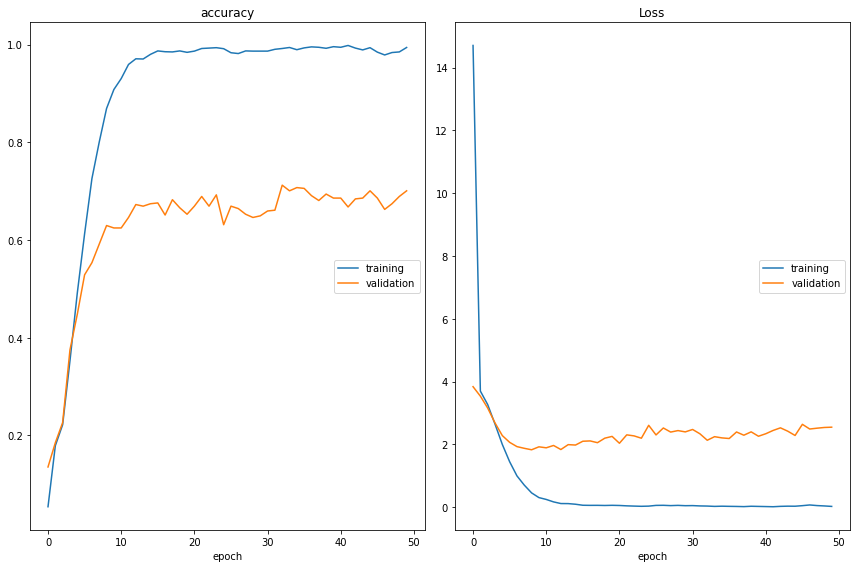

accuracy
	training         	 (min:    0.054, max:    0.998, cur:    0.994)
	validation       	 (min:    0.136, max:    0.712, cur:    0.701)
Loss
	training         	 (min:    0.010, max:   14.708, cur:    0.021)
	validation       	 (min:    1.825, max:    3.836, cur:    2.545)


Accuracy:
19/19 [==============================] - 2s 112ms/step - loss: 2.5452 - accuracy: 0.7008


time for trainin = 28 minutes



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 45, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 22, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14

In [ ]:
# Defining the cnn basic parameters
batch_size_opt = 128 
epochs_opt = 50
optimizers_opt = 'rmsprop'
dropout_opt = 0.25
conv_activation_opt ='relu'
pool_type_opt  = 'max'
start = time()

# CNN Architecture
K.clear_session()

model=Sequential()
model.add(Conv2D(64,kernel_size=3,activation=conv_activation_opt,input_shape=(W,H,1)))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Conv2D(128,kernel_size=3,activation=conv_activation_opt))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Conv2D(256,kernel_size=5,activation=conv_activation_opt))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Dropout(dropout_opt))
model.add(Flatten())
model.add(Dense(classes,activation='softmax'))

model.compile(optimizer=optimizers_opt,loss='categorical_crossentropy',metrics=['accuracy'])

# fit model
model.fit(training_data_X,training_data_Y,validation_data=(testing_data_X,testing_data_Y),\
          batch_size=batch_size_opt,epochs=epochs_opt, verbose=1, callbacks=[PlotLossesKeras()])

# model's performance on test set
print('\n\nAccuracy:')
test_loss, test_acc = model.evaluate(testing_data_X,testing_data_Y, verbose=1)

# print time for training
print('\n\ntime for trainin = {:.0f} minutes'.format((time()-start)/60))

# print model architecture
print('\n\n')
model.summary()

# B. M2: min_faces_per_person = 20 / resize=0.7

In [ ]:
# Defining images size and number images per person
min_faces_per_person = 20
resize=0.7

# Some definitions
data = fetch_lfw_people(min_faces_per_person=min_faces_per_person, resize=resize)

l=list(data.keys())
X=data[l[0]]
y=data[l[2]]
target_names=data[l[3]]

_,W,H=data[l[1]].shape
features=X.shape[1]
m=X.shape[0]
classes=data[l[3]].shape[0]

print("Images Summary")
print("Samples:",m)
print("Classes:",classes)
print("Dimentions:",(W,H))

# Train and test splitting of data
training_data_X,testing_data_X,training_data_Y,testing_data_Y=train_test_split(X,y,test_size=0.20,random_state=42)

# Data to Categorical
training_data_Y=to_categorical(training_data_Y)
testing_data_Y=to_categorical(testing_data_Y)

training_data_X=training_data_X.reshape(training_data_X.shape[0],W,H,1)
testing_data_X=testing_data_X.reshape(testing_data_X.shape[0],W,H,1)


Resumen Imágenes a procesar
Samples: 3023
Classes: 62
Dimentions: (87, 65)


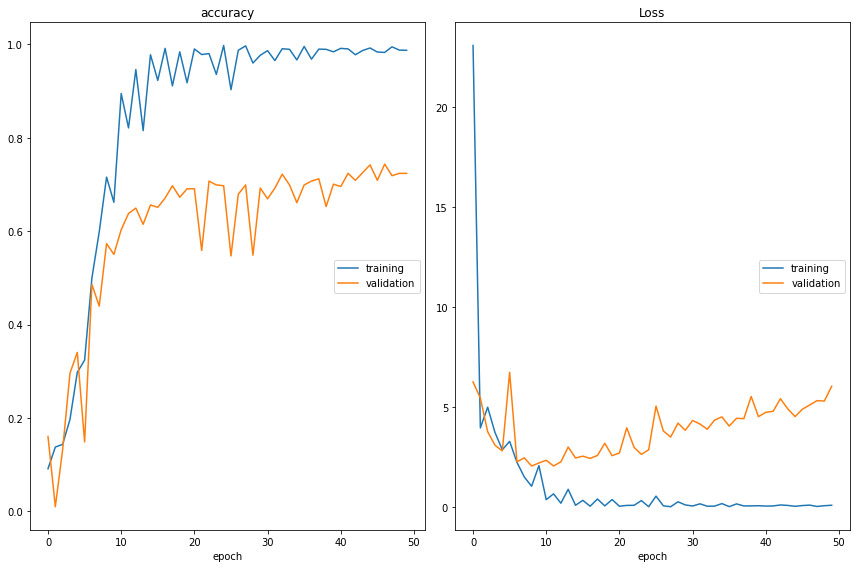

accuracy
	training         	 (min:    0.091, max:    0.998, cur:    0.988)
	validation       	 (min:    0.010, max:    0.744, cur:    0.724)
Loss
	training         	 (min:    0.008, max:   23.062, cur:    0.083)
	validation       	 (min:    2.044, max:    6.727, cur:    6.029)


Accuracy:
19/19 [==============================] - 1s 24ms/step - loss: 6.0286 - accuracy: 0.7240


time for trainin = 2 minutes



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 85, 63, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 

In [ ]:
# Defining the cnn basic parameters
batch_size_opt = 128 
epochs_opt = 50
optimizers_opt = 'rmsprop'
dropout_opt = 0.4
conv_activation_opt ='relu'
pool_type_opt  = 'max'
start = time()

# CNN Architecture
K.clear_session()

model=Sequential()
model.add(Conv2D(64,kernel_size=3,activation=conv_activation_opt,input_shape=(W,H,1)))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Conv2D(128,kernel_size=3,activation=conv_activation_opt))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Conv2D(256,kernel_size=5,activation=conv_activation_opt))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Dropout(dropout_opt))
model.add(Flatten())
model.add(Dense(classes,activation='softmax'))

model.compile(optimizer=optimizers_opt,loss='categorical_crossentropy',metrics=['accuracy'])

# fit model
model.fit(training_data_X,training_data_Y,validation_data=(testing_data_X,testing_data_Y),\
          batch_size=batch_size_opt,epochs=epochs_opt, verbose=1, callbacks=[PlotLossesKeras()])

# model's performance on test set
print('\n\nAccuracy:')
test_loss, test_acc = model.evaluate(testing_data_X,testing_data_Y, verbose=1)

# print time for training
print('\n\ntime for trainin = {:.0f} minutes'.format((time()-start)/60))

# print model architecture
print('\n\n')
model.summary()

# C. M3: min_faces_per_person = 40 / resize=0.5

In [ ]:
# Defining images size and number images per person
min_faces_per_person = 40
resize=0.5

# Some definitions
data = fetch_lfw_people(min_faces_per_person=min_faces_per_person, resize=resize)

l=list(data.keys())
X=data[l[0]]
y=data[l[2]]
target_names=data[l[3]]

_,W,H=data[l[1]].shape
features=X.shape[1]
m=X.shape[0]
classes=data[l[3]].shape[0]

print("Images Summary")
print("Samples:",m)
print("Classes:",classes)
print("Dimentions:",(W,H))

# Train and test splitting of data
training_data_X,testing_data_X,training_data_Y,testing_data_Y=train_test_split(X,y,test_size=0.20,random_state=42)

# Data to Categorical
training_data_Y=to_categorical(training_data_Y)
testing_data_Y=to_categorical(testing_data_Y)

training_data_X=training_data_X.reshape(training_data_X.shape[0],W,H,1)
testing_data_X=testing_data_X.reshape(testing_data_X.shape[0],W,H,1)


Resumen Imágenes a procesar
Samples: 1867
Classes: 19
Dimentions: (62, 47)


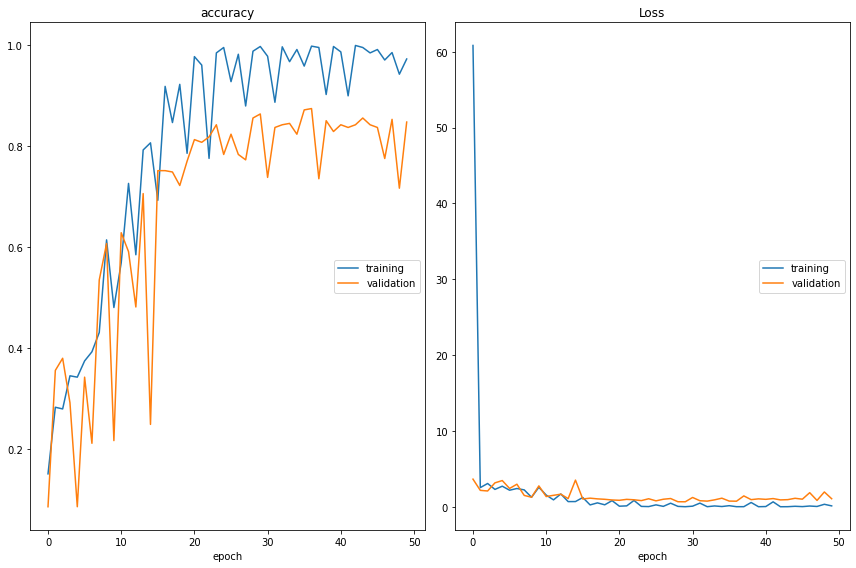

accuracy
	training         	 (min:    0.151, max:    0.999, cur:    0.973)
	validation       	 (min:    0.086, max:    0.874, cur:    0.848)
Loss
	training         	 (min:    0.006, max:   60.835, cur:    0.118)
	validation       	 (min:    0.659, max:    3.644, cur:    1.061)


Accuracy:
12/12 [==============================] - 0s 19ms/step - loss: 1.0605 - accuracy: 0.8476


time for trainin = 1 minutes



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 45, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 22, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 

In [ ]:
# Defining the cnn basic parameters
batch_size_opt = 128 
epochs_opt = 50
optimizers_opt = 'rmsprop'
dropout_opt = 0.4
conv_activation_opt ='relu'
pool_type_opt  = 'max'
start = time()

# CNN Architecture
K.clear_session()

model=Sequential()
model.add(Conv2D(64,kernel_size=3,activation=conv_activation_opt,input_shape=(W,H,1)))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Conv2D(128,kernel_size=3,activation=conv_activation_opt))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Conv2D(256,kernel_size=5,activation=conv_activation_opt))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Dropout(dropout_opt))
model.add(Flatten())
model.add(Dense(classes,activation='softmax'))

model.compile(optimizer=optimizers_opt,loss='categorical_crossentropy',metrics=['accuracy'])

# fit model
model.fit(training_data_X,training_data_Y,validation_data=(testing_data_X,testing_data_Y),\
          batch_size=batch_size_opt,epochs=epochs_opt, verbose=1, callbacks=[PlotLossesKeras()])

# model's performance on test set
print('\n\nAccuracy:')
test_loss, test_acc = model.evaluate(testing_data_X,testing_data_Y, verbose=1)

# print time for training
print('\n\ntime for trainin = {:.0f} minutes'.format((time()-start)/60))

# print model architecture
print('\n\n')
model.summary()

# D. M4: min_faces_per_person = 40 / resize=0.7

In [ ]:
# Defining images size and number images per person
min_faces_per_person = 40 
resize=0.7 

# Some definitions
data = fetch_lfw_people(min_faces_per_person=min_faces_per_person, resize=resize)

l=list(data.keys())
X=data[l[0]]
y=data[l[2]]
target_names=data[l[3]]

_,W,H=data[l[1]].shape
features=X.shape[1]
m=X.shape[0]
classes=data[l[3]].shape[0]

print("Images Summary")
print("Samples:",m)
print("Classes:",classes)
print("Dimentions:",(W,H))

# Train and test splitting of data
training_data_X,testing_data_X,training_data_Y,testing_data_Y=train_test_split(X,y,test_size=0.20,random_state=42)

# Data to Categorical
training_data_Y=to_categorical(training_data_Y)
testing_data_Y=to_categorical(testing_data_Y)

training_data_X=training_data_X.reshape(training_data_X.shape[0],W,H,1)
testing_data_X=testing_data_X.reshape(testing_data_X.shape[0],W,H,1)


Resumen Imágenes a procesar
Samples: 1867
Classes: 19
Dimentions: (87, 65)


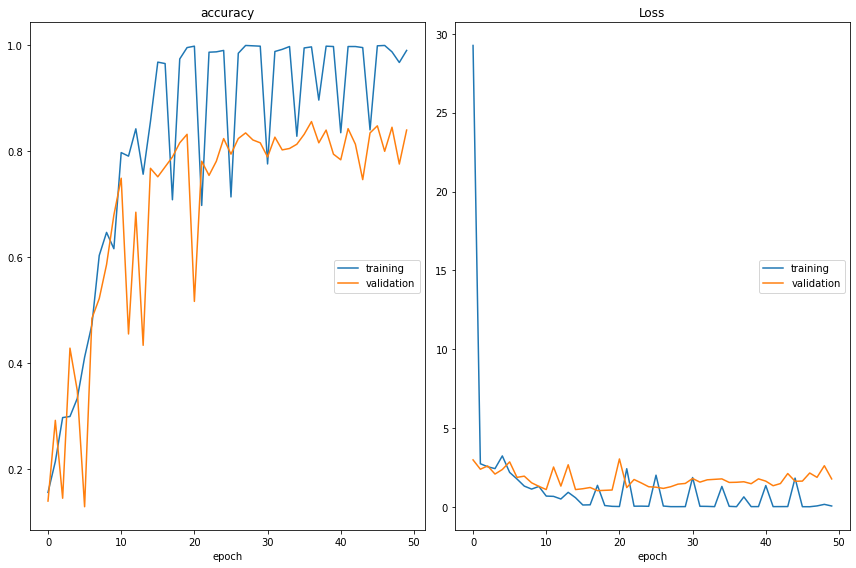

accuracy
	training         	 (min:    0.155, max:    0.999, cur:    0.990)
	validation       	 (min:    0.128, max:    0.856, cur:    0.840)
Loss
	training         	 (min:    0.002, max:   29.265, cur:    0.049)
	validation       	 (min:    1.022, max:    3.033, cur:    1.766)


Accuracy:
12/12 [==============================] - 0s 30ms/step - loss: 1.7663 - accuracy: 0.8396


time for trainin = 2 minutes



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 85, 63, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 

In [ ]:
# Defining the cnn basic parameters
batch_size_opt = 128 
epochs_opt = 50
optimizers_opt = 'rmsprop'
dropout_opt = 0.4
conv_activation_opt ='relu'
pool_type_opt  = 'max'
start = time()

# CNN Architecture
K.clear_session()

model=Sequential()
model.add(Conv2D(64,kernel_size=3,activation=conv_activation_opt,input_shape=(W,H,1)))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Conv2D(128,kernel_size=3,activation=conv_activation_opt))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Conv2D(256,kernel_size=5,activation=conv_activation_opt))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Dropout(dropout_opt))
model.add(Flatten())
model.add(Dense(classes,activation='softmax'))

model.compile(optimizer=optimizers_opt,loss='categorical_crossentropy',metrics=['accuracy'])

# fit model
model.fit(training_data_X,training_data_Y,validation_data=(testing_data_X,testing_data_Y),\
          batch_size=batch_size_opt,epochs=epochs_opt, verbose=1, callbacks=[PlotLossesKeras()])

# model's performance on test set
print('\n\nAccuracy:')
test_loss, test_acc = model.evaluate(testing_data_X,testing_data_Y, verbose=1)

# print time for training
print('\n\ntime for trainin = {:.0f} minutes'.format((time()-start)/60))

# print model architecture
print('\n\n')
model.summary()

# E. M5: min_faces_per_person = 60 / resize=0.5

In [ ]:
# Defining images size and number images per person
min_faces_per_person = 60
resize=0.5

# Some definitions
data = fetch_lfw_people(min_faces_per_person=min_faces_per_person, resize=resize)

l=list(data.keys())
X=data[l[0]]
y=data[l[2]]
target_names=data[l[3]]

_,W,H=data[l[1]].shape
features=X.shape[1]
m=X.shape[0]
classes=data[l[3]].shape[0]

print("Images Summary")
print("Samples:",m)
print("Classes:",classes)
print("Dimentions:",(W,H))

# Train and test splitting of data
training_data_X,testing_data_X,training_data_Y,testing_data_Y=train_test_split(X,y,test_size=0.20,random_state=42)

# Data to Categorical
training_data_Y=to_categorical(training_data_Y)
testing_data_Y=to_categorical(testing_data_Y)

training_data_X=training_data_X.reshape(training_data_X.shape[0],W,H,1)
testing_data_X=testing_data_X.reshape(testing_data_X.shape[0],W,H,1)


Resumen Imágenes a procesar
Samples: 1348
Classes: 8
Dimentions: (62, 47)


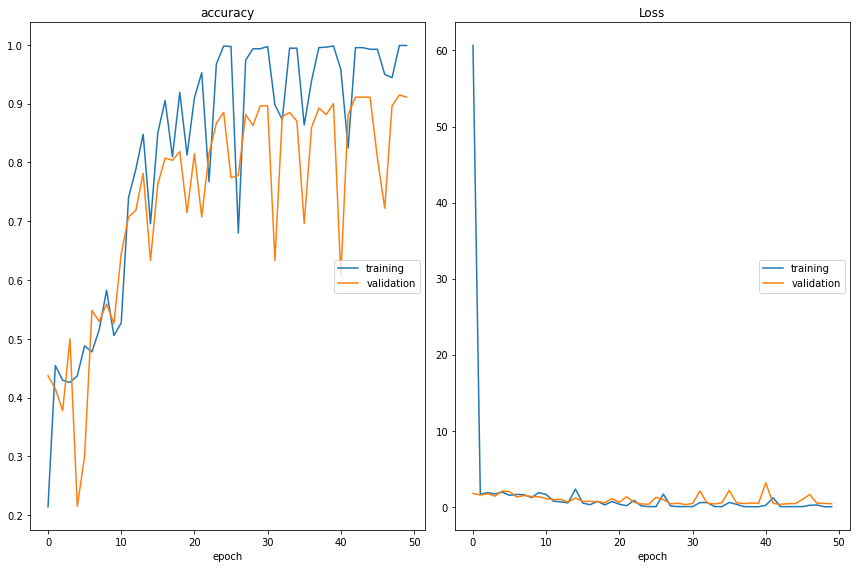

accuracy
	training         	 (min:    0.214, max:    0.999, cur:    0.999)
	validation       	 (min:    0.215, max:    0.915, cur:    0.911)
Loss
	training         	 (min:    0.003, max:   60.656, cur:    0.003)
	validation       	 (min:    0.292, max:    3.148, cur:    0.397)


Accuracy:
9/9 [==============================] - 0s 8ms/step - loss: 0.3966 - accuracy: 0.9111


time for trainin = 1 minutes



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 45, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 22, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 10,

In [ ]:
# Defining the cnn basic parameters
batch_size_opt = 128 
epochs_opt = 50
optimizers_opt = 'rmsprop'
dropout_opt = 0.4
conv_activation_opt ='relu'
pool_type_opt  = 'max'
start = time()

# CNN Architecture
K.clear_session()

model=Sequential()
model.add(Conv2D(64,kernel_size=3,activation=conv_activation_opt,input_shape=(W,H,1)))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Conv2D(128,kernel_size=3,activation=conv_activation_opt))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Conv2D(256,kernel_size=5,activation=conv_activation_opt))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Dropout(dropout_opt))
model.add(Flatten())
model.add(Dense(classes,activation='softmax'))

model.compile(optimizer=optimizers_opt,loss='categorical_crossentropy',metrics=['accuracy'])

# fit model
model.fit(training_data_X,training_data_Y,validation_data=(testing_data_X,testing_data_Y),\
          batch_size=batch_size_opt,epochs=epochs_opt, verbose=1, callbacks=[PlotLossesKeras()])

# model's performance on test set
print('\n\nAccuracy:')
test_loss, test_acc = model.evaluate(testing_data_X,testing_data_Y, verbose=1)

# print time for training
print('\n\ntime for trainin = {:.0f} minutes'.format((time()-start)/60))

# print model architecture
print('\n\n')
model.summary()

# F. M6: min_faces_per_person = 60 / resize=0.7

In [ ]:
# Defining images size and number images per person
min_faces_per_person = 60
resize=0.7

# Some definitions
data = fetch_lfw_people(min_faces_per_person=min_faces_per_person, resize=resize)

l=list(data.keys())
X=data[l[0]]
y=data[l[2]]
target_names=data[l[3]]

_,W,H=data[l[1]].shape
features=X.shape[1]
m=X.shape[0]
classes=data[l[3]].shape[0]

print("Images Summary")
print("Samples:",m)
print("Classes:",classes)
print("Dimentions:",(W,H))

# Train and test splitting of data
training_data_X,testing_data_X,training_data_Y,testing_data_Y=train_test_split(X,y,test_size=0.20,random_state=42)

# Data to Categorical
training_data_Y=to_categorical(training_data_Y)
testing_data_Y=to_categorical(testing_data_Y)

training_data_X=training_data_X.reshape(training_data_X.shape[0],W,H,1)
testing_data_X=testing_data_X.reshape(testing_data_X.shape[0],W,H,1)


Resumen Imágenes a procesar
Samples: 1348
Classes: 8
Dimentions: (87, 65)


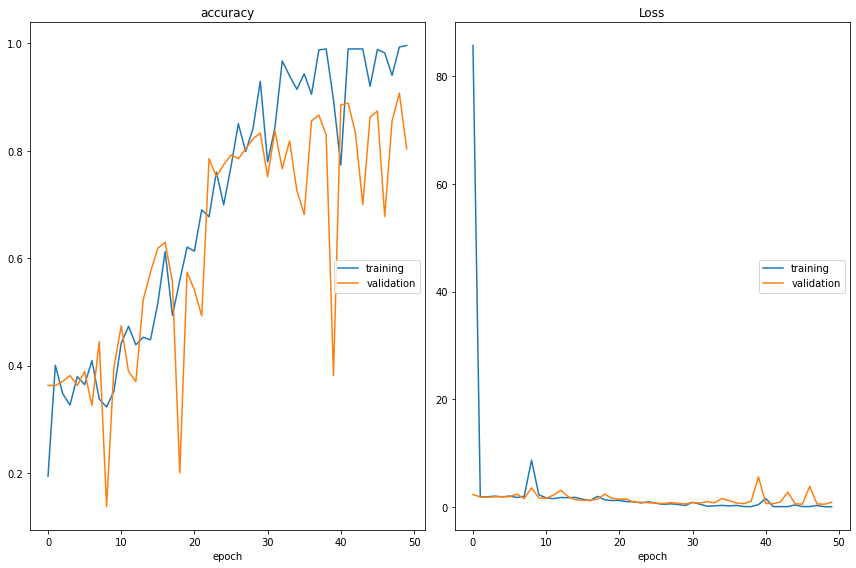

accuracy
	training         	 (min:    0.194, max:    0.996, cur:    0.996)
	validation       	 (min:    0.137, max:    0.907, cur:    0.804)
Loss
	training         	 (min:    0.011, max:   85.747, cur:    0.011)
	validation       	 (min:    0.473, max:    5.566, cur:    0.859)


Accuracy:
9/9 [==============================] - 0s 13ms/step - loss: 0.8592 - accuracy: 0.8037


time for trainin = 1 minutes



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 85, 63, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 14

In [ ]:
# Defining the cnn basic parameters
batch_size_opt = 128 
epochs_opt = 50
optimizers_opt = 'rmsprop'
dropout_opt = 0.4
conv_activation_opt ='relu'
pool_type_opt  = 'max'
start = time()

# CNN Architecture
K.clear_session()

model=Sequential()
model.add(Conv2D(64,kernel_size=3,activation=conv_activation_opt,input_shape=(W,H,1)))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Conv2D(128,kernel_size=3,activation=conv_activation_opt))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Conv2D(256,kernel_size=5,activation=conv_activation_opt))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Dropout(dropout_opt))
model.add(Flatten())
model.add(Dense(classes,activation='softmax'))

model.compile(optimizer=optimizers_opt,loss='categorical_crossentropy',metrics=['accuracy'])

# fit model
model.fit(training_data_X,training_data_Y,validation_data=(testing_data_X,testing_data_Y),\
          batch_size=batch_size_opt,epochs=epochs_opt, verbose=1, callbacks=[PlotLossesKeras()])

# model's performance on test set
print('\n\nAccuracy:')
test_loss, test_acc = model.evaluate(testing_data_X,testing_data_Y, verbose=1)

# print time for training
print('\n\ntime for trainin = {:.0f} minutes'.format((time()-start)/60))

# print model architecture
print('\n\n')
model.summary()

# G. M7: min_faces_per_person = 70 / resize=0.5

In [ ]:
# Defining images size and number images per person
min_faces_per_person = 70
resize=0.5

# Some definitions
data = fetch_lfw_people(min_faces_per_person=min_faces_per_person, resize=resize)

l=list(data.keys())
X=data[l[0]]
y=data[l[2]]
target_names=data[l[3]]

_,W,H=data[l[1]].shape
features=X.shape[1]
m=X.shape[0]
classes=data[l[3]].shape[0]

print("Images Summary")
print("Samples:",m)
print("Classes:",classes)
print("Dimentions:",(W,H))

# Train and test splitting of data
training_data_X,testing_data_X,training_data_Y,testing_data_Y=train_test_split(X,y,test_size=0.20,random_state=42)

# Data to Categorical
training_data_Y=to_categorical(training_data_Y)
testing_data_Y=to_categorical(testing_data_Y)

training_data_X=training_data_X.reshape(training_data_X.shape[0],W,H,1)
testing_data_X=testing_data_X.reshape(testing_data_X.shape[0],W,H,1)


Resumen Imágenes a procesar
Samples: 1288
Classes: 7
Dimentions: (62, 47)


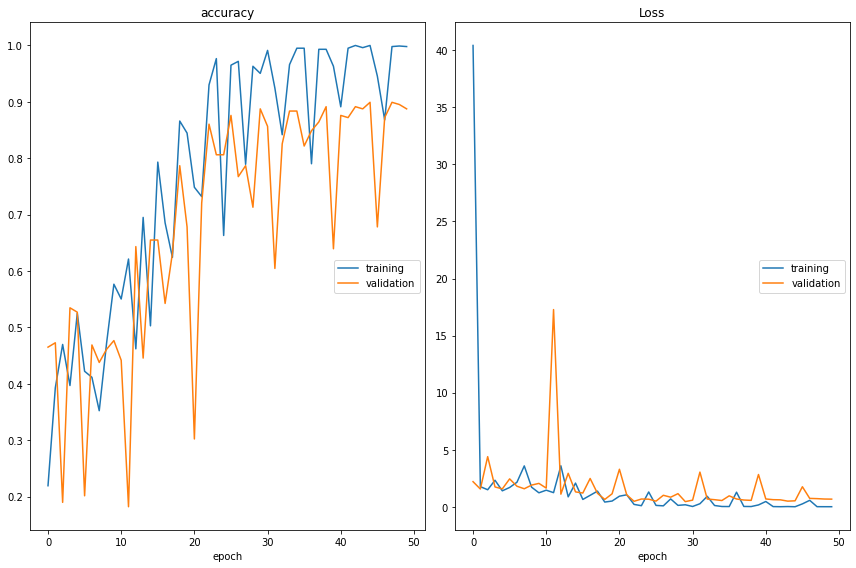

accuracy
	training         	 (min:    0.219, max:    1.000, cur:    0.998)
	validation       	 (min:    0.182, max:    0.899, cur:    0.888)
Loss
	training         	 (min:    0.002, max:   40.427, cur:    0.005)
	validation       	 (min:    0.451, max:   17.281, cur:    0.668)


Accuracy:
9/9 [==============================] - 0s 9ms/step - loss: 0.6685 - accuracy: 0.8876


time for trainin = 2 minutes



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 45, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 22, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 10,

In [ ]:
# Defining the cnn basic parameters
batch_size_opt = 128 
epochs_opt = 50
optimizers_opt = 'rmsprop'
dropout_opt = 0.4
conv_activation_opt ='relu'
pool_type_opt  = 'max'
start = time()

# CNN Architecture
K.clear_session()

model=Sequential()
model.add(Conv2D(64,kernel_size=3,activation=conv_activation_opt,input_shape=(W,H,1)))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Conv2D(128,kernel_size=3,activation=conv_activation_opt))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Conv2D(256,kernel_size=5,activation=conv_activation_opt))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Dropout(dropout_opt))
model.add(Flatten())
model.add(Dense(classes,activation='softmax'))

model.compile(optimizer=optimizers_opt,loss='categorical_crossentropy',metrics=['accuracy'])

# fit model
model.fit(training_data_X,training_data_Y,validation_data=(testing_data_X,testing_data_Y),\
          batch_size=batch_size_opt,epochs=epochs_opt, verbose=1, callbacks=[PlotLossesKeras()])

# model's performance on test set
print('\n\nAccuracy:')
test_loss, test_acc = model.evaluate(testing_data_X,testing_data_Y, verbose=1)

# print time for training
print('\n\ntime for trainin = {:.0f} minutes'.format((time()-start)/60))

# print model architecture
print('\n\n')
model.summary()

# H. M8: min_faces_per_person = 70 / resize=0.7

In [ ]:
# Defining images size and number images per person
min_faces_per_person = 70
resize=0.7

# Some definitions
data = fetch_lfw_people(min_faces_per_person=min_faces_per_person, resize=resize)

l=list(data.keys())
X=data[l[0]]
y=data[l[2]]
target_names=data[l[3]]

_,W,H=data[l[1]].shape
features=X.shape[1]
m=X.shape[0]
classes=data[l[3]].shape[0]

print("Images Summary")
print("Samples:",m)
print("Classes:",classes)
print("Dimentions:",(W,H))

# Train and test splitting of data
training_data_X,testing_data_X,training_data_Y,testing_data_Y=train_test_split(X,y,test_size=0.20,random_state=42)

# Data to Categorical
training_data_Y=to_categorical(training_data_Y)
testing_data_Y=to_categorical(testing_data_Y)

training_data_X=training_data_X.reshape(training_data_X.shape[0],W,H,1)
testing_data_X=testing_data_X.reshape(testing_data_X.shape[0],W,H,1)


Resumen Imágenes a procesar
Samples: 1288
Classes: 7
Dimentions: (87, 65)


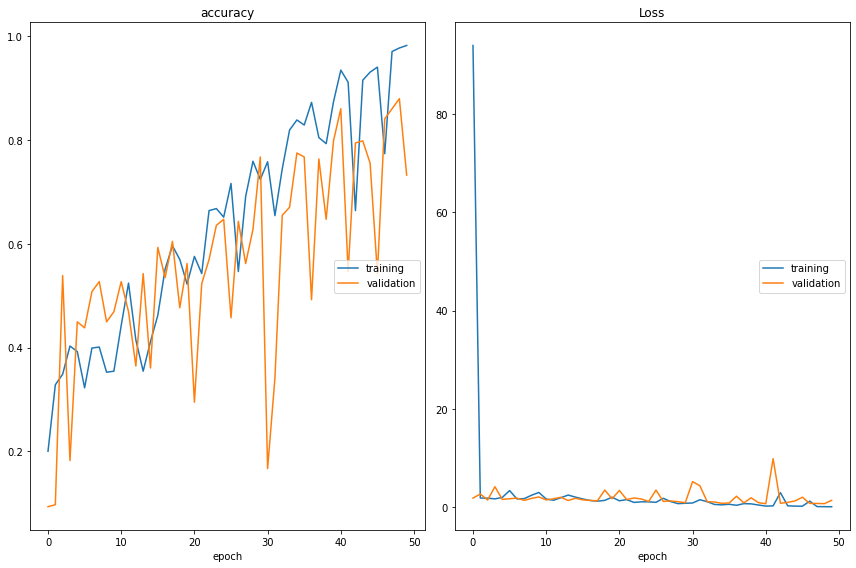

accuracy
	training         	 (min:    0.200, max:    0.983, cur:    0.983)
	validation       	 (min:    0.093, max:    0.880, cur:    0.733)
Loss
	training         	 (min:    0.066, max:   94.014, cur:    0.066)
	validation       	 (min:    0.679, max:    9.851, cur:    1.366)


Accuracy:
9/9 [==============================] - 0s 12ms/step - loss: 1.3660 - accuracy: 0.7326


time for trainin = 1 minutes



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 85, 63, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 14

In [ ]:
# Defining the cnn basic parameters
batch_size_opt = 128 
epochs_opt = 50
optimizers_opt = 'rmsprop'
dropout_opt = 0.4
conv_activation_opt ='relu'
pool_type_opt  = 'max'
start = time()

# CNN Architecture
K.clear_session()

model=Sequential()
model.add(Conv2D(64,kernel_size=3,activation=conv_activation_opt,input_shape=(W,H,1)))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Conv2D(128,kernel_size=3,activation=conv_activation_opt))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Conv2D(256,kernel_size=5,activation=conv_activation_opt))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Dropout(dropout_opt))
model.add(Flatten())
model.add(Dense(classes,activation='softmax'))

model.compile(optimizer=optimizers_opt,loss='categorical_crossentropy',metrics=['accuracy'])

# fit model
model.fit(training_data_X,training_data_Y,validation_data=(testing_data_X,testing_data_Y),\
          batch_size=batch_size_opt,epochs=epochs_opt, verbose=1, callbacks=[PlotLossesKeras()])

# model's performance on test set
print('\n\nAccuracy:')
test_loss, test_acc = model.evaluate(testing_data_X,testing_data_Y, verbose=1)

# print time for training
print('\n\ntime for trainin = {:.0f} minutes'.format((time()-start)/60))

# print model architecture
print('\n\n')
model.summary()

# **Selected:**
# **min_faces_per_person = 60 / resize=0.5**

### **GRID SEARCH HYPERPARAMETERS - CNN**


In [ ]:
# Defining images size and number images per person
min_faces_per_person = 60
resize=0.5

# Some definitions
data = fetch_lfw_people(min_faces_per_person=min_faces_per_person, resize=resize)

l=list(data.keys())
X=data[l[0]]
y=data[l[2]]
target_names=data[l[3]]

_,W,H=data[l[1]].shape
features=X.shape[1]
m=X.shape[0]
classes=data[l[3]].shape[0]

print("Images Summary")
print("Samples:",m)
print("Classes:",classes)
print("Dimentions:",(W,H))

# Train and test splitting of data
training_data_X,testing_data_X,training_data_Y,testing_data_Y=train_test_split(X,y,test_size=0.20,random_state=42)

# Data to Categorical
training_data_Y=to_categorical(training_data_Y)
testing_data_Y=to_categorical(testing_data_Y)

training_data_X=training_data_X.reshape(training_data_X.shape[0],W,H,1)
testing_data_X=testing_data_X.reshape(testing_data_X.shape[0],W,H,1)


Resumen Imágenes a procesar
Samples: 1348
Classes: 8
Dimentions: (62, 47)


In [ ]:
# function to create the model for Keras wrapper to scikit learn
def create_cnn_model(pool_type='max', conv_activation='sigmoid', dropout_rate=0.10, optimizer = 'adam'):
    # create model
    # CNN model
    K.clear_session()
    model = Sequential()

    # first layer: convolution
    model.add(Conv2D(64,kernel_size=3,activation='relu',input_shape=(W,H,1)))
    if pool_type == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
    if pool_type == 'average':
        model.add(AveragePooling2D(pool_size=(2, 2),strides=(2,2)))
    
    # second series of layers: convolution, pooling
    model.add(Conv2D(128,kernel_size=3,activation='relu'))
    if pool_type == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
    if pool_type == 'average':
        model.add(AveragePooling2D(pool_size=(2, 2),strides=(2,2)))

    # third series of layers: convolution, pooling, and dropout    
    model.add(Conv2D(256,kernel_size=5,activation='relu'))
    if pool_type == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
    if pool_type == 'average':
        model.add(AveragePooling2D(pool_size=(2, 2),strides=(2,2)))
    
    # Dropout
    model.add(Dropout(rate=dropout_rate))     
    # fourth series
    model.add(Flatten())         
    
    # ouput layer
    model.add(Dense(classes,activation='softmax'))
    
    # Compile model
    model.compile( 
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        )    
    return model




 ### GridSearch 

In [ ]:
# Defining the Hyperparameters tunning

model = KerasClassifier(build_fn=create_cnn_model, verbose=1)
n_cv = 10

#batch_size_opt= [64,128,256,512] 
#epochs_opt= [25,50,75]
#optimizers_opt = ['adam', 'rmsprop','adamax']
#dropout_opt = [0.1,0.2,0.3,0.4,0.5]
#conv_activation_opt = ['relu','sigmoid']
#pool_type_opt  = ['max', 'average']
batch_size_opt= [128] 
epochs_opt= [65]
optimizers_opt = ['adam', 'rmsprop',]
dropout_opt = [0.3,0.4,0.5]
conv_activation_opt = ['relu']
pool_type_opt  = ['max']

parameters_opt = {
                  'pool_type': pool_type_opt,
                  'conv_activation': conv_activation_opt,    
                  'dropout_rate' : dropout_opt,
                  'optimizer': optimizers_opt,
                  'batch_size': batch_size_opt, 
                  'epochs': epochs_opt,      
                 }

grid_search = GridSearchCV(estimator=model, 
                           param_grid =parameters_opt, 
                           n_jobs=-1,
                           cv = n_cv)





In [ ]:
# Runing GridSearchCV
start = time()
grid_result = grid_search.fit(training_data_X, training_data_Y, verbose = 0)
print('\n\ntime for grid search = {:.0f} hours'.format((time()-start)/3600))
print('\n\ntime for grid search = {:.0f} minutes'.format((time()-start)/60))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning




time for grid search = 0 hours


time for grid search = 28 minutes


In [ ]:
# Print the GridSearchCV results
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_
print(best_parameters)
print(best_accuracy)

{'batch_size': 128, 'conv_activation': 'relu', 'dropout_rate': 0.5, 'epochs': 65, 'optimizer': 'adam', 'pool_type': 'max'}
0.8933108389377594


## **Se corre la red por última vez con los parámetros, encontrados:**



*   batch_size: 128
*   conv_activation: relu
*   dropout_rate: 0.5
*   epochs: 65
*   optimizer: adam
*   pool_type: max
*   resize:0.5
*   min_faces_per_person: 60






In [ ]:
# Defining images size and number images per person
min_faces_per_person = 60
resize=0.5

# Some definitions
data = fetch_lfw_people(min_faces_per_person=min_faces_per_person, resize=resize)

l=list(data.keys())
X=data[l[0]]
y=data[l[2]]
target_names=data[l[3]]

_,W,H=data[l[1]].shape
features=X.shape[1]
m=X.shape[0]
classes=data[l[3]].shape[0]

print("Images Summary")
print("Samples:",m)
print("Classes:",classes)
print("Dimentions:",(W,H))

# Train and test splitting of data
training_data_X,testing_data_X,training_data_Y,testing_data_Y=train_test_split(X,y,test_size=0.20,random_state=42)

# Data to Categorical
training_data_Y=to_categorical(training_data_Y)
testing_data_Y=to_categorical(testing_data_Y)

training_data_X=training_data_X.reshape(training_data_X.shape[0],W,H,1)
testing_data_X=testing_data_X.reshape(testing_data_X.shape[0],W,H,1)


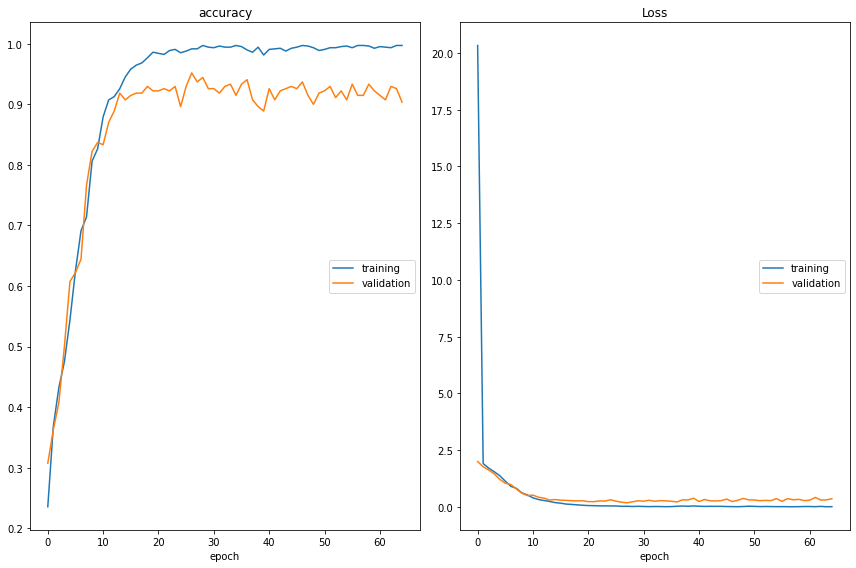

accuracy
	training         	 (min:    0.236, max:    0.997, cur:    0.997)
	validation       	 (min:    0.307, max:    0.952, cur:    0.904)
Loss
	training         	 (min:    0.012, max:   20.330, cur:    0.015)
	validation       	 (min:    0.186, max:    2.003, cur:    0.364)


Accuracy:
9/9 [==============================] - 0s 9ms/step - loss: 0.3640 - accuracy: 0.9037


time for trainin = 1 minutes



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 45, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 22, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 10,

In [ ]:
# Defining the cnn basic parameters
batch_size_opt = 128 
epochs_opt = 65
optimizers_opt = 'adam'
dropout_opt = 0.5
conv_activation_opt ='relu'
pool_type_opt  = 'max'
start = time()

# CNN Architecture
K.clear_session()

model=Sequential()
model.add(Conv2D(64,kernel_size=3,activation=conv_activation_opt,input_shape=(W,H,1)))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Conv2D(128,kernel_size=3,activation=conv_activation_opt))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Conv2D(256,kernel_size=5,activation=conv_activation_opt))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Dropout(dropout_opt))
model.add(Flatten())
model.add(Dense(classes,activation='softmax'))

model.compile(optimizer=optimizers_opt,loss='categorical_crossentropy',metrics=['accuracy'])

# fit model
model.fit(training_data_X,training_data_Y,validation_data=(testing_data_X,testing_data_Y),\
          batch_size=batch_size_opt,epochs=epochs_opt, verbose=1, callbacks=[PlotLossesKeras()])

# model's performance on test set
print('\n\nAccuracy:')
test_loss, test_acc = model.evaluate(testing_data_X,testing_data_Y, verbose=1)

# print time for training
print('\n\ntime for trainin = {:.0f} minutes'.format((time()-start)/60))

# print model architecture
print('\n\n')
model.summary()

In [7]:
# Defining images size and number images per person
min_faces_per_person = 40
resize=0.5

# Some definitions
data = fetch_lfw_people(min_faces_per_person=min_faces_per_person, resize=resize)

l=list(data.keys())
X=data[l[0]]
y=data[l[2]]
target_names=data[l[3]]

_,W,H=data[l[1]].shape
features=X.shape[1]
m=X.shape[0]
classes=data[l[3]].shape[0]

print("Images Summary")
print("Samples:",m)
print("Classes:",classes)
print("Dimentions:",(W,H))

# Train and test splitting of data
training_data_X,testing_data_X,training_data_Y,testing_data_Y=train_test_split(X,y,test_size=0.20,random_state=42)

# Data to Categorical
training_data_Y=to_categorical(training_data_Y)
testing_data_Y=to_categorical(testing_data_Y)

training_data_X=training_data_X.reshape(training_data_X.shape[0],W,H,1)
testing_data_X=testing_data_X.reshape(testing_data_X.shape[0],W,H,1)


Images Summary
Samples: 1867
Classes: 19
Dimentions: (62, 47)


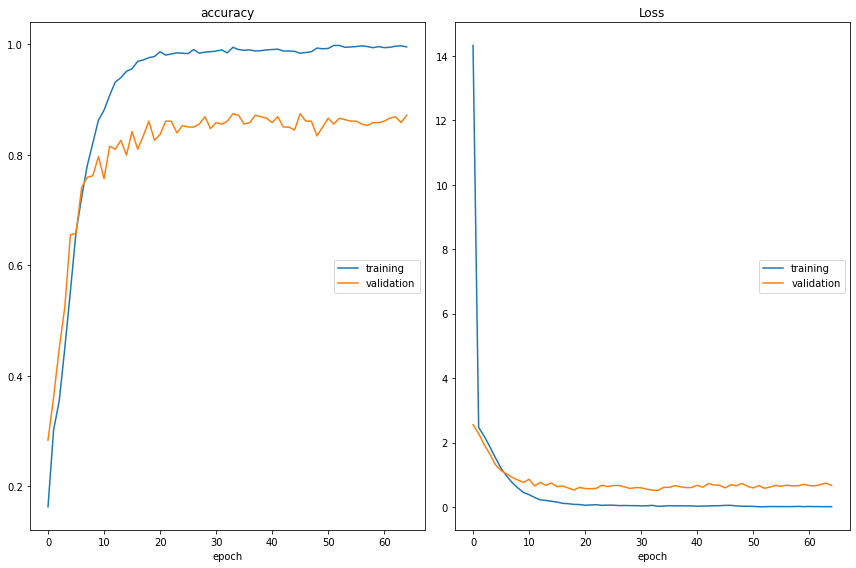

accuracy
	training         	 (min:    0.163, max:    0.998, cur:    0.995)
	validation       	 (min:    0.283, max:    0.874, cur:    0.872)
Loss
	training         	 (min:    0.009, max:   14.320, cur:    0.012)
	validation       	 (min:    0.516, max:    2.554, cur:    0.670)


Accuracy:
12/12 [==============================] - 0s 10ms/step - loss: 0.6703 - accuracy: 0.8717


time for trainin = 1 minutes



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 45, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 22, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 

In [10]:
# Defining the cnn basic parameters
batch_size_opt = 128 
epochs_opt = 65
optimizers_opt = 'adam'
dropout_opt = 0.5
conv_activation_opt ='relu'
pool_type_opt  = 'max'
start = time()

# CNN Architecture
K.clear_session()

model=Sequential()
model.add(Conv2D(64,kernel_size=3,activation=conv_activation_opt,input_shape=(W,H,1)))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Conv2D(128,kernel_size=3,activation=conv_activation_opt))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Conv2D(256,kernel_size=5,activation=conv_activation_opt))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Dropout(dropout_opt))
model.add(Flatten())
model.add(Dense(classes,activation='softmax'))

model.compile(optimizer=optimizers_opt,loss='categorical_crossentropy',metrics=['accuracy'])

# fit model
model.fit(training_data_X,training_data_Y,validation_data=(testing_data_X,testing_data_Y),\
          batch_size=batch_size_opt,epochs=epochs_opt, verbose=1, callbacks=[PlotLossesKeras()])

# model's performance on test set
print('\n\nAccuracy:')
test_loss, test_acc = model.evaluate(testing_data_X,testing_data_Y, verbose=1)

# print time for training
print('\n\ntime for trainin = {:.0f} minutes'.format((time()-start)/60))

# print model architecture
print('\n\n')
model.summary()